In [27]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/brandonjacques/anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['e', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [28]:
import os
from collections import namedtuple
import numpy as np
import pandas as pd
import random
from scipy.spatial.distance import pdist, squareform
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from catch import Catch

from sith import SITH
from memory_hash import HashedMemory

# if gpu is to be used
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
IntTensor = torch.cuda.IntTensor if use_cuda else torch.IntTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor
print(use_cuda)

False


In [29]:
"""
Reinforcement learning without going too deep.
"""

class SithRL(object):
    """SITH-based Successor Representation"""
    def __init__(self, state_len, action_len,
                 alpha=.5, neg_scaling=100., num_decays=20,
                 info_rate=1./30., dt=1./30./10., dur=1./30./10.,
                 dtype=np.float32):
        
        # save the vars
        self._dtype = dtype
        self._state_len = state_len
        self._action_len = action_len
        
        # Parameters for SITH
        self._info_rate = info_rate
        self._dt = dt
        self._dur = dur
        self._delay = info_rate - dt
        
        # Parameters for Picking Action
        self._num_decays = num_decays
        self._alpha = alpha
        self._neg_scaling = neg_scaling
        
        self.history = None
        
        # init sith
        self._in_sith = state_len
        self._sith = SITH(self._in_sith, dt=self._dt, tau_0=self._info_rate, ntau=25, dtype=self._dtype, use_cuda=use_cuda)

        # allocate for M
        self._in_M = self._sith.T.size()[0]
        self._M = torch.zeros((self._action_len, self._state_len, self._in_M)).type(FloatTensor) # (actions, outM, inM)

    def reset_T(self):
        self._sith.reset()

    def add_memory(self, state, reward):
        curr_history = torch.cat((state.view(1, -1), self._sith.T.view(-1).unsqueeze(0),
                                  FloatTensor([reward]).unsqueeze(0)),
                                  1)
        if self.history is None:
            self.history = curr_history
        else:

            self.history = torch.cat((self.history, curr_history), 0)
        
    
    def norm_M(self):
        # Normalize M Boi
        l1_normalized = torch.zeros(self._action_len,
                                    self._state_len,
                                    self._sith.tau_star[self._sith._T_full_ind].size-1,
                                    self._in_sith).type(FloatTensor)

        for i in range(self._action_len):
            l1_normalized[i] = self._M[i].view(self._state_len,
                                                self._sith.tau_star[self._sith._T_full_ind].size-1,
                                                self._in_sith)

            denom = torch.abs(l1_normalized[i]).sum(0).unsqueeze(0)
            denom[denom == 0.0] = 1.0
            normalized = l1_normalized[i]/denom.expand_as(l1_normalized[i])
            l1_normalized[i] = normalized
            
        self.l1_normalized = l1_normalized.view(model._action_len, model._state_len, (model._sith.tau_star[model._sith._T_full_ind].size-1)*model._in_sith)
       
    def pick_action(self, state):
        
        # grab the actual SITH, the first *in_sith* features are just the latest screen. 
        h = model.history[:, self._in_sith:-1].clone()
        
        # Save our rards for later
        rewards = self.history[:,-1]

        # Save t
        save_t = self._sith._t.clone()
        
        self._sith.update_t(state*self._dt, dur=self._dur)
        self._sith.update_t(item=None, dur=self._delay)
        
        # Init Potential Future Matches
        pfm_list = None
        
        # Loop over actions, calculate the prediction error for current SITH and potential future histories
        # To help select a goal state. 
        for i in range(self._num_decays):
            # Input new state+action into SITH
            pe = h - self._sith.T.view(1, -1).expand_as(h)
            
            # Sum all the positive prediction error and negative predition error
            w = 1./(1.+((pe*(pe>0).type(FloatTensor)).sum(1) + (-1 * self._neg_scaling)*(pe*(pe<0).type(FloatTensor)).sum(1)))

            if pfm_list is None:
                pfm_list = (w*rewards).clone().view(1, -1)
            else:
                pfm_list = torch.cat((pfm_list, (w*rewards).clone().view(1, -1)), 0)

            self._sith.update_t(item=None, dur=model._delay+model._dt)

        # return back to previous t
        self._sith._t = save_t
        self._sith._t_changed = True
        
        
        # PICK THE GOAL STATE BABY
        goal_state = self.history[pfm_list.cpu().numpy().sum(0).argmax(), :-1]
        goal_state = goal_state.view(self._sith.tau_star[self._sith._T_full_ind].size, self._in_sith)
        goal_state = goal_state[0].clone()
        goal_state = goal_state.view(-1)
        
        # Scaled by total PFR over drifts
        upd_pfm_list = pfm_list/pfm_list.sum(0).expand_as(pfm_list)

        # Initialize the Action to goal_state probabilities
        action_to_goal_prob = torch.zeros(self._action_len).type(FloatTensor)
        tau_pos = [0, 1, 3, 7, 15]
        
        for pos in range(self._action_len):
            ss = None
            
            for i in range(self._sith.tau_star[self._sith._T_full_ind].size-1):
                if i == 0:
                    sa_p = torch.cat((state, torch.zeros((self._sith.T.size(0) - state.size(0), 1)).type(FloatTensor)), 0)
                elif i == self._sith.tau_star[self._sith._T_full_ind].size-2:
                    sa_p = torch.cat((torch.zeros((state.size(0)*i, 1)).type(FloatTensor), state), 0)
                else:
                    sa_p = torch.cat((torch.zeros((state.size(0)*i, 1)).type(FloatTensor), state, torch.zeros((self._sith.T.size(0) - state.size(0)*(i+1), 1)).type(FloatTensor)), 0)
                
                ss = self.l1_normalized[pos].mm(sa_p).view(-1)
                action_to_goal_prob[pos] += ((ss - goal_state).dot((ss - goal_state)))*upd_pfm_list[tau_pos[i], pfm_list.cpu().numpy().sum(0).argmax()]
            
            # return back to previous t
            self._sith._t = save_t
            self._sith._t_changed = True
            
        return action_to_goal_prob.min(0)[1]

    def update_T(self, state):
        # update T with that state action
        self._sith.update_t(item=state.view(-1)*self._dt, dur=self._dur)
        self._sith.update_t(item=None, dur=self._delay)
        
    def learn_step(self, next_state, action):
        # Update the M associated with action *action* 
        self._M[action] += self._alpha * next_state.unsqueeze(1).mm(self._sith.T.unsqueeze(0))

 

In [30]:
# global params
height = 18
width=12
num_actions = 3
input_size = width * height

model = SithRL(state_len=input_size, action_len=num_actions, 
               neg_scaling=100., alpha=.001)

In [31]:
# set up the catch environment
c = Catch(screen_height=height, screen_width=width,
          game_over_conditions = {'ball_deletions': 1},
          mask=0, ball_spawn_rate=100000, basket_len=3)

In [32]:
training_random = 5000
training_games = 5000
test_every = 5000
testing_games = 1

In [33]:
tot_score = 0.0
training_rewards = []
testing_rewards = []
# train over total epochs
for e in range(training_games):
    c.reset()
    model.reset_T()
    game_over = False
    # get initial input
    input_t = Tensor(c.observe(flatten=True))
    i = 0
    #iterate over each game
    if (np.random.rand() <= (.5 - .5*(float(e)/training_games) )) or (model.history is None) or (e < training_random):
        RUN_RANDOM = True
    else:
        RUN_RANDOM = False
    while not game_over:

        # t_-1 is the previous observation
        input_tm1 = input_t.clone()
        model.update_T(state=input_tm1)

        # Randomly pick an action, or use the
        # Previously calculated action
        if (RUN_RANDOM):
            action = (torch.rand(1) * (num_actions)).type(LongTensor)
        else:
            action = model.pick_action(input_tm1)


        # apply action, get rewards and new state
        reward, timestep, game_over = c.act(action.cpu().numpy()[0]-1)

        input_t = Tensor(c.observe(flatten=True))

        # store experience
        model.learn_step(next_state=input_t, action=action.cpu().numpy()[0])
       
        
        if reward != 0:
            save_t = model._sith._t.clone()
            model.update_T(state=input_t)
            model.add_memory(input_t, reward)
            tot_score += reward
            training_rewards += [reward]
            print(e, ": ", tot_score, reward)    
            model._sith._t = save_t.clone()
            model._sith._t_changed = True
    if (e % test_every == 0):
        model.norm_M()
        test_score = 0.0
        for i in range(testing_games):
            c.reset()
            model.reset_T()
            game_over = False
            # get initial input
            input_t = Tensor(c.observe(flatten=True))
            
            #iterate over each game
            while not game_over:

                # t_-1 is the previous observation
                input_tm1 = input_t.clone()
                model.update_T(state=input_tm1)

                # Randomly pick an action, or use the
                # Previously calculated action
                action = model.pick_action(input_tm1)


                # apply action, get rewards and new state
                reward, timestep, game_over = c.act(action.cpu().numpy()[0]-1)

                input_t = Tensor(c.observe(flatten=True))

                # store experience
                #model.learn_step(next_state=input_t, action=action.cpu().numpy()[0])


                if reward != 0:
                    test_score += reward
        print("TEST ", e, ": ", test_score/testing_games)   
        testing_rewards += [test_score/testing_games]
            

0 :  -1.0 -1
TEST  0 :  -1.0
1 :  0.0 1
2 :  1.0 1
3 :  2.0 1
4 :  1.0 -1
5 :  0.0 -1
6 :  -1.0 -1
7 :  -2.0 -1
8 :  -3.0 -1
9 :  -4.0 -1
10 :  -5.0 -1
11 :  -6.0 -1
12 :  -7.0 -1
13 :  -6.0 1
14 :  -7.0 -1
15 :  -8.0 -1
16 :  -9.0 -1
17 :  -10.0 -1
18 :  -9.0 1
19 :  -8.0 1
20 :  -7.0 1
21 :  -8.0 -1
22 :  -7.0 1
23 :  -6.0 1
24 :  -7.0 -1
25 :  -6.0 1
26 :  -7.0 -1
27 :  -8.0 -1
28 :  -7.0 1
29 :  -6.0 1
30 :  -7.0 -1
31 :  -8.0 -1
32 :  -9.0 -1
33 :  -10.0 -1
34 :  -11.0 -1
35 :  -12.0 -1
36 :  -13.0 -1
37 :  -14.0 -1
38 :  -15.0 -1
39 :  -16.0 -1
40 :  -17.0 -1
41 :  -18.0 -1
42 :  -19.0 -1
43 :  -20.0 -1
44 :  -21.0 -1
45 :  -22.0 -1
46 :  -23.0 -1
47 :  -24.0 -1
48 :  -23.0 1
49 :  -24.0 -1
50 :  -25.0 -1
51 :  -24.0 1
52 :  -25.0 -1
53 :  -24.0 1
54 :  -25.0 -1
55 :  -26.0 -1
56 :  -25.0 1
57 :  -26.0 -1
58 :  -25.0 1
59 :  -24.0 1
60 :  -25.0 -1
61 :  -26.0 -1
62 :  -27.0 -1
63 :  -28.0 -1
64 :  -29.0 -1
65 :  -30.0 -1
66 :  -31.0 -1
67 :  -30.0 1
68 :  -29.0 1
69 :  -28.0 1
70

512 :  -253.0 -1
513 :  -254.0 -1
514 :  -255.0 -1
515 :  -254.0 1
516 :  -255.0 -1
517 :  -256.0 -1
518 :  -257.0 -1
519 :  -256.0 1
520 :  -257.0 -1
521 :  -258.0 -1
522 :  -259.0 -1
523 :  -258.0 1
524 :  -259.0 -1
525 :  -260.0 -1
526 :  -261.0 -1
527 :  -262.0 -1
528 :  -263.0 -1
529 :  -264.0 -1
530 :  -263.0 1
531 :  -262.0 1
532 :  -263.0 -1
533 :  -262.0 1
534 :  -263.0 -1
535 :  -264.0 -1
536 :  -265.0 -1
537 :  -266.0 -1
538 :  -267.0 -1
539 :  -266.0 1
540 :  -267.0 -1
541 :  -266.0 1
542 :  -267.0 -1
543 :  -268.0 -1
544 :  -269.0 -1
545 :  -268.0 1
546 :  -267.0 1
547 :  -268.0 -1
548 :  -269.0 -1
549 :  -270.0 -1
550 :  -271.0 -1
551 :  -272.0 -1
552 :  -273.0 -1
553 :  -272.0 1
554 :  -273.0 -1
555 :  -274.0 -1
556 :  -273.0 1
557 :  -274.0 -1
558 :  -275.0 -1
559 :  -276.0 -1
560 :  -277.0 -1
561 :  -278.0 -1
562 :  -277.0 1
563 :  -278.0 -1
564 :  -279.0 -1
565 :  -280.0 -1
566 :  -279.0 1
567 :  -278.0 1
568 :  -277.0 1
569 :  -278.0 -1
570 :  -277.0 1
571 :  -278.0 

1015 :  -496.0 1
1016 :  -497.0 -1
1017 :  -498.0 -1
1018 :  -499.0 -1
1019 :  -500.0 -1
1020 :  -501.0 -1
1021 :  -502.0 -1
1022 :  -503.0 -1
1023 :  -504.0 -1
1024 :  -505.0 -1
1025 :  -506.0 -1
1026 :  -507.0 -1
1027 :  -506.0 1
1028 :  -507.0 -1
1029 :  -508.0 -1
1030 :  -509.0 -1
1031 :  -510.0 -1
1032 :  -509.0 1
1033 :  -510.0 -1
1034 :  -511.0 -1
1035 :  -510.0 1
1036 :  -511.0 -1
1037 :  -512.0 -1
1038 :  -513.0 -1
1039 :  -512.0 1
1040 :  -511.0 1
1041 :  -512.0 -1
1042 :  -513.0 -1
1043 :  -514.0 -1
1044 :  -515.0 -1
1045 :  -516.0 -1
1046 :  -517.0 -1
1047 :  -518.0 -1
1048 :  -519.0 -1
1049 :  -518.0 1
1050 :  -517.0 1
1051 :  -516.0 1
1052 :  -517.0 -1
1053 :  -518.0 -1
1054 :  -519.0 -1
1055 :  -520.0 -1
1056 :  -519.0 1
1057 :  -520.0 -1
1058 :  -521.0 -1
1059 :  -520.0 1
1060 :  -521.0 -1
1061 :  -522.0 -1
1062 :  -523.0 -1
1063 :  -524.0 -1
1064 :  -525.0 -1
1065 :  -526.0 -1
1066 :  -525.0 1
1067 :  -526.0 -1
1068 :  -527.0 -1
1069 :  -526.0 1
1070 :  -527.0 -1
1071 

1482 :  -731.0 1
1483 :  -730.0 1
1484 :  -731.0 -1
1485 :  -730.0 1
1486 :  -731.0 -1
1487 :  -730.0 1
1488 :  -731.0 -1
1489 :  -732.0 -1
1490 :  -733.0 -1
1491 :  -734.0 -1
1492 :  -735.0 -1
1493 :  -736.0 -1
1494 :  -737.0 -1
1495 :  -738.0 -1
1496 :  -739.0 -1
1497 :  -738.0 1
1498 :  -739.0 -1
1499 :  -740.0 -1
1500 :  -741.0 -1
1501 :  -742.0 -1
1502 :  -743.0 -1
1503 :  -744.0 -1
1504 :  -743.0 1
1505 :  -742.0 1
1506 :  -743.0 -1
1507 :  -744.0 -1
1508 :  -745.0 -1
1509 :  -746.0 -1
1510 :  -747.0 -1
1511 :  -748.0 -1
1512 :  -749.0 -1
1513 :  -748.0 1
1514 :  -749.0 -1
1515 :  -750.0 -1
1516 :  -751.0 -1
1517 :  -752.0 -1
1518 :  -751.0 1
1519 :  -752.0 -1
1520 :  -753.0 -1
1521 :  -754.0 -1
1522 :  -755.0 -1
1523 :  -756.0 -1
1524 :  -757.0 -1
1525 :  -758.0 -1
1526 :  -759.0 -1
1527 :  -758.0 1
1528 :  -759.0 -1
1529 :  -760.0 -1
1530 :  -759.0 1
1531 :  -758.0 1
1532 :  -757.0 1
1533 :  -758.0 -1
1534 :  -757.0 1
1535 :  -756.0 1
1536 :  -757.0 -1
1537 :  -756.0 1
1538 :  

1945 :  -964.0 -1
1946 :  -965.0 -1
1947 :  -964.0 1
1948 :  -965.0 -1
1949 :  -966.0 -1
1950 :  -965.0 1
1951 :  -966.0 -1
1952 :  -967.0 -1
1953 :  -968.0 -1
1954 :  -969.0 -1
1955 :  -970.0 -1
1956 :  -971.0 -1
1957 :  -970.0 1
1958 :  -969.0 1
1959 :  -970.0 -1
1960 :  -971.0 -1
1961 :  -972.0 -1
1962 :  -973.0 -1
1963 :  -974.0 -1
1964 :  -973.0 1
1965 :  -974.0 -1
1966 :  -975.0 -1
1967 :  -976.0 -1
1968 :  -977.0 -1
1969 :  -978.0 -1
1970 :  -977.0 1
1971 :  -978.0 -1
1972 :  -979.0 -1
1973 :  -978.0 1
1974 :  -979.0 -1
1975 :  -978.0 1
1976 :  -979.0 -1
1977 :  -980.0 -1
1978 :  -981.0 -1
1979 :  -982.0 -1
1980 :  -983.0 -1
1981 :  -984.0 -1
1982 :  -985.0 -1
1983 :  -986.0 -1
1984 :  -987.0 -1
1985 :  -988.0 -1
1986 :  -989.0 -1
1987 :  -988.0 1
1988 :  -989.0 -1
1989 :  -990.0 -1
1990 :  -991.0 -1
1991 :  -992.0 -1
1992 :  -991.0 1
1993 :  -990.0 1
1994 :  -989.0 1
1995 :  -988.0 1
1996 :  -989.0 -1
1997 :  -990.0 -1
1998 :  -991.0 -1
1999 :  -990.0 1
2000 :  -991.0 -1
2001 :

2398 :  -1175.0 -1
2399 :  -1176.0 -1
2400 :  -1177.0 -1
2401 :  -1178.0 -1
2402 :  -1179.0 -1
2403 :  -1180.0 -1
2404 :  -1181.0 -1
2405 :  -1180.0 1
2406 :  -1179.0 1
2407 :  -1180.0 -1
2408 :  -1179.0 1
2409 :  -1180.0 -1
2410 :  -1181.0 -1
2411 :  -1182.0 -1
2412 :  -1181.0 1
2413 :  -1182.0 -1
2414 :  -1181.0 1
2415 :  -1180.0 1
2416 :  -1179.0 1
2417 :  -1178.0 1
2418 :  -1177.0 1
2419 :  -1178.0 -1
2420 :  -1179.0 -1
2421 :  -1180.0 -1
2422 :  -1179.0 1
2423 :  -1180.0 -1
2424 :  -1181.0 -1
2425 :  -1180.0 1
2426 :  -1181.0 -1
2427 :  -1182.0 -1
2428 :  -1183.0 -1
2429 :  -1184.0 -1
2430 :  -1183.0 1
2431 :  -1184.0 -1
2432 :  -1183.0 1
2433 :  -1184.0 -1
2434 :  -1185.0 -1
2435 :  -1186.0 -1
2436 :  -1187.0 -1
2437 :  -1188.0 -1
2438 :  -1189.0 -1
2439 :  -1188.0 1
2440 :  -1189.0 -1
2441 :  -1190.0 -1
2442 :  -1189.0 1
2443 :  -1190.0 -1
2444 :  -1189.0 1
2445 :  -1190.0 -1
2446 :  -1191.0 -1
2447 :  -1192.0 -1
2448 :  -1193.0 -1
2449 :  -1194.0 -1
2450 :  -1195.0 -1
2451 :  -

2845 :  -1396.0 -1
2846 :  -1395.0 1
2847 :  -1396.0 -1
2848 :  -1395.0 1
2849 :  -1394.0 1
2850 :  -1395.0 -1
2851 :  -1394.0 1
2852 :  -1395.0 -1
2853 :  -1396.0 -1
2854 :  -1397.0 -1
2855 :  -1398.0 -1
2856 :  -1397.0 1
2857 :  -1398.0 -1
2858 :  -1399.0 -1
2859 :  -1400.0 -1
2860 :  -1399.0 1
2861 :  -1400.0 -1
2862 :  -1401.0 -1
2863 :  -1402.0 -1
2864 :  -1401.0 1
2865 :  -1400.0 1
2866 :  -1401.0 -1
2867 :  -1400.0 1
2868 :  -1401.0 -1
2869 :  -1400.0 1
2870 :  -1401.0 -1
2871 :  -1402.0 -1
2872 :  -1401.0 1
2873 :  -1402.0 -1
2874 :  -1403.0 -1
2875 :  -1404.0 -1
2876 :  -1405.0 -1
2877 :  -1406.0 -1
2878 :  -1407.0 -1
2879 :  -1408.0 -1
2880 :  -1409.0 -1
2881 :  -1410.0 -1
2882 :  -1411.0 -1
2883 :  -1412.0 -1
2884 :  -1413.0 -1
2885 :  -1414.0 -1
2886 :  -1415.0 -1
2887 :  -1416.0 -1
2888 :  -1417.0 -1
2889 :  -1416.0 1
2890 :  -1415.0 1
2891 :  -1416.0 -1
2892 :  -1417.0 -1
2893 :  -1416.0 1
2894 :  -1417.0 -1
2895 :  -1418.0 -1
2896 :  -1419.0 -1
2897 :  -1420.0 -1
2898 : 

3283 :  -1612.0 1
3284 :  -1613.0 -1
3285 :  -1614.0 -1
3286 :  -1615.0 -1
3287 :  -1616.0 -1
3288 :  -1615.0 1
3289 :  -1616.0 -1
3290 :  -1617.0 -1
3291 :  -1616.0 1
3292 :  -1617.0 -1
3293 :  -1618.0 -1
3294 :  -1619.0 -1
3295 :  -1620.0 -1
3296 :  -1621.0 -1
3297 :  -1622.0 -1
3298 :  -1623.0 -1
3299 :  -1624.0 -1
3300 :  -1623.0 1
3301 :  -1624.0 -1
3302 :  -1625.0 -1
3303 :  -1626.0 -1
3304 :  -1627.0 -1
3305 :  -1628.0 -1
3306 :  -1627.0 1
3307 :  -1628.0 -1
3308 :  -1629.0 -1
3309 :  -1630.0 -1
3310 :  -1631.0 -1
3311 :  -1632.0 -1
3312 :  -1633.0 -1
3313 :  -1632.0 1
3314 :  -1631.0 1
3315 :  -1632.0 -1
3316 :  -1633.0 -1
3317 :  -1634.0 -1
3318 :  -1635.0 -1
3319 :  -1636.0 -1
3320 :  -1637.0 -1
3321 :  -1638.0 -1
3322 :  -1639.0 -1
3323 :  -1640.0 -1
3324 :  -1641.0 -1
3325 :  -1642.0 -1
3326 :  -1643.0 -1
3327 :  -1644.0 -1
3328 :  -1645.0 -1
3329 :  -1646.0 -1
3330 :  -1645.0 1
3331 :  -1646.0 -1
3332 :  -1647.0 -1
3333 :  -1646.0 1
3334 :  -1647.0 -1
3335 :  -1648.0 -1
33

3726 :  -1859.0 -1
3727 :  -1858.0 1
3728 :  -1857.0 1
3729 :  -1858.0 -1
3730 :  -1857.0 1
3731 :  -1856.0 1
3732 :  -1857.0 -1
3733 :  -1858.0 -1
3734 :  -1857.0 1
3735 :  -1858.0 -1
3736 :  -1857.0 1
3737 :  -1858.0 -1
3738 :  -1857.0 1
3739 :  -1858.0 -1
3740 :  -1859.0 -1
3741 :  -1860.0 -1
3742 :  -1861.0 -1
3743 :  -1862.0 -1
3744 :  -1861.0 1
3745 :  -1862.0 -1
3746 :  -1863.0 -1
3747 :  -1864.0 -1
3748 :  -1865.0 -1
3749 :  -1866.0 -1
3750 :  -1867.0 -1
3751 :  -1866.0 1
3752 :  -1867.0 -1
3753 :  -1868.0 -1
3754 :  -1867.0 1
3755 :  -1868.0 -1
3756 :  -1867.0 1
3757 :  -1868.0 -1
3758 :  -1869.0 -1
3759 :  -1870.0 -1
3760 :  -1871.0 -1
3761 :  -1872.0 -1
3762 :  -1873.0 -1
3763 :  -1874.0 -1
3764 :  -1875.0 -1
3765 :  -1874.0 1
3766 :  -1875.0 -1
3767 :  -1876.0 -1
3768 :  -1877.0 -1
3769 :  -1878.0 -1
3770 :  -1879.0 -1
3771 :  -1878.0 1
3772 :  -1879.0 -1
3773 :  -1880.0 -1
3774 :  -1881.0 -1
3775 :  -1882.0 -1
3776 :  -1883.0 -1
3777 :  -1884.0 -1
3778 :  -1885.0 -1
3779 :

4170 :  -2085.0 -1
4171 :  -2086.0 -1
4172 :  -2085.0 1
4173 :  -2086.0 -1
4174 :  -2085.0 1
4175 :  -2086.0 -1
4176 :  -2087.0 -1
4177 :  -2088.0 -1
4178 :  -2089.0 -1
4179 :  -2090.0 -1
4180 :  -2091.0 -1
4181 :  -2092.0 -1
4182 :  -2093.0 -1
4183 :  -2094.0 -1
4184 :  -2095.0 -1
4185 :  -2094.0 1
4186 :  -2093.0 1
4187 :  -2094.0 -1
4188 :  -2095.0 -1
4189 :  -2096.0 -1
4190 :  -2095.0 1
4191 :  -2096.0 -1
4192 :  -2097.0 -1
4193 :  -2096.0 1
4194 :  -2095.0 1
4195 :  -2096.0 -1
4196 :  -2097.0 -1
4197 :  -2096.0 1
4198 :  -2097.0 -1
4199 :  -2098.0 -1
4200 :  -2097.0 1
4201 :  -2096.0 1
4202 :  -2097.0 -1
4203 :  -2098.0 -1
4204 :  -2099.0 -1
4205 :  -2100.0 -1
4206 :  -2101.0 -1
4207 :  -2100.0 1
4208 :  -2101.0 -1
4209 :  -2102.0 -1
4210 :  -2101.0 1
4211 :  -2102.0 -1
4212 :  -2103.0 -1
4213 :  -2104.0 -1
4214 :  -2105.0 -1
4215 :  -2106.0 -1
4216 :  -2105.0 1
4217 :  -2106.0 -1
4218 :  -2107.0 -1
4219 :  -2108.0 -1
4220 :  -2109.0 -1
4221 :  -2110.0 -1
4222 :  -2109.0 1
4223 : 

4612 :  -2299.0 -1
4613 :  -2300.0 -1
4614 :  -2301.0 -1
4615 :  -2302.0 -1
4616 :  -2303.0 -1
4617 :  -2304.0 -1
4618 :  -2305.0 -1
4619 :  -2306.0 -1
4620 :  -2305.0 1
4621 :  -2306.0 -1
4622 :  -2307.0 -1
4623 :  -2308.0 -1
4624 :  -2307.0 1
4625 :  -2308.0 -1
4626 :  -2307.0 1
4627 :  -2308.0 -1
4628 :  -2309.0 -1
4629 :  -2310.0 -1
4630 :  -2311.0 -1
4631 :  -2312.0 -1
4632 :  -2313.0 -1
4633 :  -2314.0 -1
4634 :  -2315.0 -1
4635 :  -2316.0 -1
4636 :  -2317.0 -1
4637 :  -2318.0 -1
4638 :  -2319.0 -1
4639 :  -2320.0 -1
4640 :  -2321.0 -1
4641 :  -2322.0 -1
4642 :  -2323.0 -1
4643 :  -2324.0 -1
4644 :  -2323.0 1
4645 :  -2324.0 -1
4646 :  -2325.0 -1
4647 :  -2326.0 -1
4648 :  -2327.0 -1
4649 :  -2326.0 1
4650 :  -2325.0 1
4651 :  -2326.0 -1
4652 :  -2327.0 -1
4653 :  -2328.0 -1
4654 :  -2329.0 -1
4655 :  -2328.0 1
4656 :  -2327.0 1
4657 :  -2326.0 1
4658 :  -2327.0 -1
4659 :  -2326.0 1
4660 :  -2327.0 -1
4661 :  -2326.0 1
4662 :  -2327.0 -1
4663 :  -2328.0 -1
4664 :  -2329.0 -1
4665

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(13, 10))
trrewards = np.array(training_rewards).cumsum()
terewards = np.array(testing_rewards)
ax[0].plot(trrewards)
ax[1].plot([x for x in range(0, 4999, 50)], terewards,)


In [ ]:
[x for x in range(3100, 4999, 100)]

In [ ]:
pdist = nn.PairwiseDistance()

In [ ]:
history_t.view(1297, 5000).gather(1, (history_t[:, -1] > 0).unsqueeze(1).type(LongTensor))

In [ ]:
history_t.index_select(0, (history_t[:, -1] > 0).type(LongTensor))

In [ ]:
torch.dist(history_t[623,18*12:-1], history_t[603,18*12:-1], p=3)

In [ ]:
A = history_t[0, 18*12:-1]
B = history_t[1:, 18*12:-1]
TwoAB = 2 * A @ B.transpose(0,1)
print(torch.sqrt(torch.sum(A * A, 1).expand_as(TwoAB) + torch.sum(B * B, 1).transpose(0,1).expand_as(TwoAB) - TwoAB))


In [ ]:
d = pdist(history[history[:,-1] > 0][:,18*12:-1], "euclidean")

In [ ]:
squareform(d)[squareform(d) < .05]

In [ ]:
imshow(squareform(d))
colorbar()

In [ ]:
a = sns.clustermap(squareform(d))

In [ ]:
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(15,10))
i = 623
ax1.matshow(torch.cat((history_t[i, 18*12:18*12*2].view(18,12), history_t[i, 18*12*2:18*12*3].view(18,12), 
                   history_t[i, 18*12*3:18*12*4].view(18,12), history_t[i, 18*12*4:18*12*5].view(18,12),
                   history_t[i, 18*12*5:18*12*6].view(18,12)), 1))
i = 865
ax2.imshow(torch.cat((history_t[i, 18*12:18*12*2].view(18,12), history_t[i, 18*12*2:18*12*3].view(18,12), 
                   history_t[i, 18*12*3:18*12*4].view(18,12), history_t[i, 18*12*4:18*12*5].view(18,12),
                   history_t[i, 18*12*5:18*12*6].view(18,12)), 1))

In [ ]:
pe = history_t[623, 18*12:-1].expand_as( history_t[:, 18*12:-1]) - history_t[:, 18*12:-1]

In [ ]:
(pe*pe).sum(0)

In [ ]:
a.data2d

In [ ]:
imshow(squareform(ds))
colorbar()

In [ ]:
tot_score = 0.0

# train over total epochs
for e in range(training_games):
    c.reset()
    model.reset_T()
    game_over = False
    # get initial input
    input_t = Tensor(c.observe(flatten=True))
    i = 0
    #iterate over each game
    while not game_over:

        # t_-1 is the previous observation
        input_tm1 = input_t.clone()
        model.update_T(state=input_tm1)

        # Randomly pick an action, or use the
        # Previously calculated action
        if (np.random.rand() <= (.5 - .5*(float(e)/training_games) )) or (model.history is None):
            action = (torch.rand(1) * (num_actions)).type(LongTensor)
        else:
            action = model.pick_action(input_tm1)


        # apply action, get rewards and new state
        reward, timestep, game_over = c.act(action.cpu().numpy()[0]-1)

        input_t = Tensor(c.observe(flatten=True))

        # store experience
        model.learn_step(next_state=input_t, action=action.cpu().numpy()[0])
       
        
        if reward != 0:
            save_t = model._sith._t.clone()
            model.update_T(state=input_t)
            model.add_memory(input_t, reward)
            tot_score += reward
            print(e, ": ", tot_score, reward)    
            model._sith._t = save_t.clone()
            model._sith._t_changed = True 

In [ ]:
tot_score = 0.0

# train over total epochs
for e in range(1000):
    c.reset()
    model.reset_T()
    game_over = False
    # get initial input
    input_t = Tensor(c.observe(flatten=True))
    i = 0
    #iterate over each game
    while not game_over:
    #while i < 100:
        # t_-1 is the previous observation
        input_tm1 = input_t.clone()
        model.update_T(state=input_tm1)

        # Randomly pick an action, or use the
        # Previously calculated action
        action = model.pick_action(input_tm1)

        # apply action, get rewards and new state
        reward, timestep, game_over = c.act(action.cpu().numpy()[0]-1)
        
        input_t = Tensor(c.observe(flatten=True))

        # store experience
        model.learn_step(next_state=input_t, action=action.cpu().numpy()[0])
        
        if reward != 0:
            tot_score += reward
            print(e, ": ", tot_score, reward)    
          
    # Reset Game and Model Queue when the game is over.
print(tot_score / 1000.)

In [ ]:
print("Creating animation...")
plt.style.use('classic')
i = 0

def animate(mat):
    global i
    i+=1
    print(i)
    return plt.imshow(mat, cmap='gray', interpolation='none'),

fig=plt.figure()
#anim = animation.FuncAnimation(fig, animate, frames = frames_stack[0:2], interval=(1.0/30.0)*1000, blit=True)
anim = animation.FuncAnimation(fig, animate, frames = frames_stack[51:102], interval=(1.0/30.0)*1000*5, blit=True)
rc('animation', html='html5')
HTML(anim.to_html5_video())

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=1, nrows=3, figsize=(15,10))
tt = ax1.matshow(model._M[0].cpu().numpy())
fig.colorbar(tt, ax=ax1)
tt = ax2.matshow(model._M[1].cpu().numpy())
fig.colorbar(tt, ax=ax2)
tt = ax3.matshow(model._M[2].cpu().numpy())
fig.colorbar(tt, ax=ax3)


In [ ]:
l1_normalized = torch.zeros(model._action_len,
                              model._state_len,
                              model._sith.tau_star[model._sith._T_full_ind].size-1,
                              model._in_sith).type(FloatTensor)

for i in range(model._action_len):
    l1_normalized[i] = model._M[i].view(model._state_len,
                                  model._sith.tau_star[model._sith._T_full_ind].size-1,
                                  model._in_sith)

    denom = torch.abs(l1_normalized[i]).sum(0).unsqueeze(0)
    denom[denom == 0.0] = 1.0
    normalized = l1_normalized[i]/denom.expand_as(l1_normalized[i])
    l1_normalized[i] = normalized
l1_normalized = l1_normalized.view(model._action_len, model._state_len, (model._sith.tau_star[model._sith._T_full_ind].size-1)*model._in_sith)


In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=1, nrows=3, figsize=(15,10))
tt = ax1.matshow(l1_normalized[0].cpu().numpy())
fig.colorbar(tt, ax=ax1)
tt = ax2.matshow(l1_normalized[1].cpu().numpy())
fig.colorbar(tt, ax=ax2)
tt = ax3.matshow(l1_normalized[2].cpu().numpy())
fig.colorbar(tt, ax=ax3)


In [ ]:
model._sith.tau_star[model._sith._T_full_ind]

In [47]:
history = model.history
model.norm_M()

M = model.l1_normalized

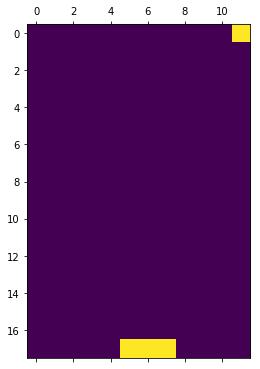

In [155]:
c.reset()
model.reset_T()
input_t = Tensor(c.observe(flatten=True))
matshow(input_t.view(18,12).cpu().numpy())

[ 1.]


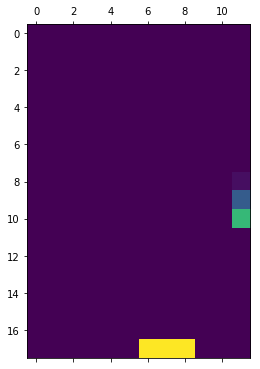

In [166]:
 # t_-1 is the previous observation
input_tm1 = input_t.clone()


# Randomly pick an action, or use the
# Previously calculated action
#if (np.random.rand() <= per_random_act) or (model.history is None):

action = torch.zeros(1).type(FloatTensor)
action[0] = 1

# apply action, get rewards and new state
reward, timestep, game_over = c.act(action.cpu().numpy()[0]-1)

# t_0, current timestep
input_t = Tensor(c.observe(flatten=True))

# store experience
#model.learn_step(state=input_tm1, action=action.cpu().numpy()[0])
model.update_T(state=input_tm1)
print(action.cpu().numpy())
if reward != 0:
    #save_t = model._sith._t.clone()
    #model.update_T(state=input_t)
    #model.add_memory(reward)
    tot_score += reward
    print(e, ": ", tot_score, reward)
    #model._sith._t = save_t.clone()
    #model._sith._t_changed = True
matshow(model._sith.T[:18*12].view(18,12).cpu().numpy())

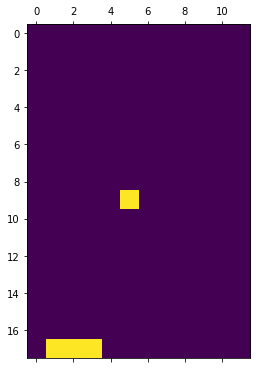

In [148]:

matshow(input_t.view(18,12).cpu().numpy())

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=6, figsize=(20,10))
t_save = model._sith._t.clone()

for i in range(6):
    ms = ax[0][i].matshow(M[0].mm(model._sith.T.view(-1, 1)).view(18,12).cpu().numpy())
    colorbar(ms, ax=ax[0][i])
    ms = ax[2][i].matshow(M[2].mm(model._sith.T.view(-1, 1)).view(18,12).cpu().numpy())
    colorbar(ms, ax=ax[2][i])
    ms = ax[1][i].matshow(M[2].mm(model._sith.T.view(-1, 1)).view(18,12).cpu().numpy() - 
                          M[0].mm(model._sith.T.view(-1, 1)).view(18,12).cpu().numpy())
    colorbar(ms, ax=ax[1][i])
    model._sith.update_t(item=None, dur=model._delay+model._dt)

    
    
model._sith._t = t_save.clone()
model._sith._t_changed = True

In [ ]:
model._sith._t = t_save.clone()
model._sith._t_changed = True

In [170]:

num_decays = 20

state = input_t.clone()
# Compress Histories (WHY DO I HAVE TO SUBTRACT 1 FROM THE SIZE OF TAUSTAR?????)
h = model.history[:, 18*12:-1].clone()

pfr_csum = torch.zeros(model.history.size(0)).type(FloatTensor)
pfr_list = torch.zeros(3, num_decays, model.history.size(0)).type(FloatTensor)
pfr_csum_list = None
# Save our rards for later
rewards = model.history[:,-1]

# Save t
save_t = model._sith._t.clone()
for a in range(3):
    model._sith.update_t(state*model._dt, dur=model._dur)
    model._sith.update_t(item=None, dur=model._delay)
    sp = M[a].mm(model._sith.T.view(-1, 1)).view(-1)

    sp = sp/sp.max(0)[0]

    model._sith.update_t(sp*model._dt, dur=model._dur)
    model._sith.update_t(item=None, dur=model._delay)
    
    # Loop over actions
    for i in range(num_decays):
        # Input new state+action into SITH
        pe = h - model._sith.T.view(1, -1).expand_as(h)
        # Sum all the positive prediction error and negative predition error
        #print(((pe*(pe>0).type(FloatTensor))).sum(1), (-20)*(pe*(pe<0).type(FloatTensor)).sum(1))
        w = 1./(1.+((1*(pe*(pe>0).type(FloatTensor))).sum(1) + (-100)*(pe*(pe<0).type(FloatTensor)).sum(1)))
        # Multiply w by the reward and sum all values together. Add to the list of potential action rewards

        
        pfr_list[a, i] = (w*(rewards*(rewards<0).type(FloatTensor))).clone().view(-1)

        model._sith.update_t(item=None, dur=model._delay+model._dt)

    # return back to previous t
    model._sith._t = save_t
    model._sith._t_changed = True


In [23]:
    # return back to previous t
    model._sith._t = save_t
    model._sith._t_changed = True

In [ ]:
print(M, model._sith.T)
sp = M.mm(model._sith.T.view(-1, 1)).view(-1)


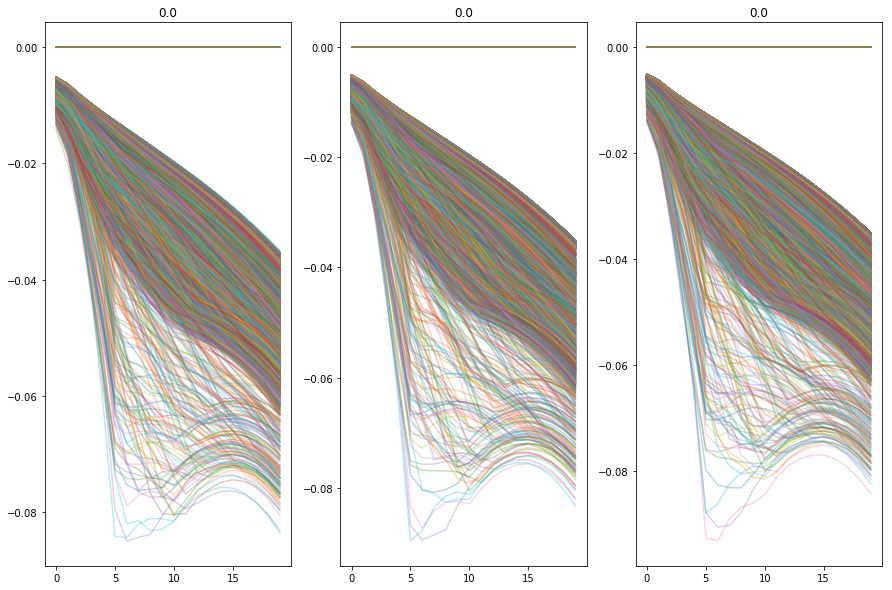

In [171]:

fig, ax = plt.subplots(ncols=3, figsize=(15,10))
for x in range(3):
    a = ax[x].plot(pfr_list[x].cpu().numpy(), alpha=.3);
    ax[x].set_title(pfr_list[x].cpu().numpy().sum(0).max())

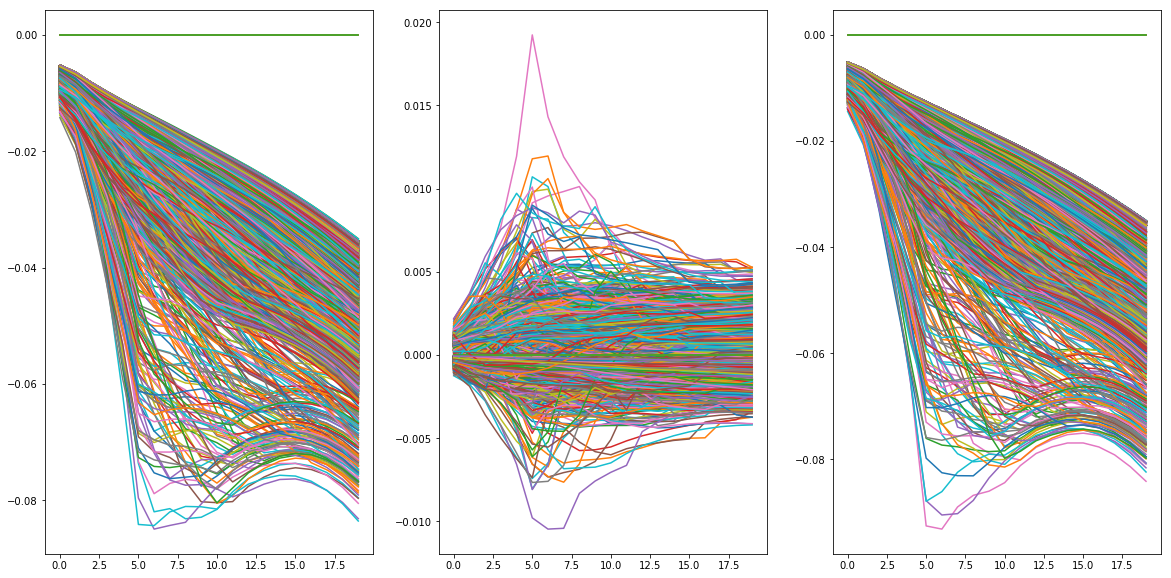

In [172]:

fig, ax = plt.subplots(ncols=3, figsize=(20,10))
a = ax[0].plot(pfr_list[0].cpu().numpy(), alpha=1);
a = ax[2].plot(pfr_list[2].cpu().numpy(), alpha=1);
a = ax[1].plot((pfr_list[0].cpu().numpy() - pfr_list[2].cpu().numpy()), alpha=1);

array([-0.00020162, -0.00025012, -0.00026782, -0.00028168, -0.00028588,
       -0.00029078, -0.00029832, -0.00030713, -0.00031364, -0.00032116,
       -0.0003243 , -0.0003218 , -0.00032261, -0.00032524, -0.00033023,
       -0.00033835, -0.00034915, -0.00036318, -0.00037959, -0.00039888], dtype=float32)

In [ ]:

state = input_t.clone()
upd_pfr_list = pfr_list/pfr_list.sum(0).expand_as(pfr_list)

a = model.history[pfr_list.cpu().numpy().sum(0).argmax(), :-1]
a = a.view(6, 100)
a = a[0].clone()
a = a.view(-1)

pos = [0, 1, 3, 7, 15]

#RIGHT
choice = 2
tot = 0.0

sal_p = torch.cat((state, torch.zeros((model._sith.T.size(0) - state.size(0), 1)).type(FloatTensor)), 0)
ssl = l1_normalized[choice].mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[0, pfr_list.cpu().numpy().sum(0).argmax()]
sal_p = torch.cat((torch.zeros((state.size(0)*1, 1)).type(FloatTensor), state, torch.zeros((model._sith.T.size(0) - state.size(0)*2, 1)).type(FloatTensor)), 0)
ssl = l1_normalized[choice].mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[1, pfr_list.cpu().numpy().sum(0).argmax()]
sal_p = torch.cat((torch.zeros((state.size(0)*2, 1)).type(FloatTensor), state, torch.zeros((model._sith.T.size(0) - state.size(0)*3, 1)).type(FloatTensor)), 0)
ssl = l1_normalized[choice].mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[3, pfr_list.cpu().numpy().sum(0).argmax()]
sal_p = torch.cat((torch.zeros((state.size(0)*3, 1)).type(FloatTensor), state, torch.zeros((model._sith.T.size(0) - state.size(0)*4, 1)).type(FloatTensor)), 0)
ssl = l1_normalized[choice].mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[7, pfr_list.cpu().numpy().sum(0).argmax()]
sal_p = torch.cat((torch.zeros((state.size(0)*4, 1)).type(FloatTensor), state), 0)
ssl = l1_normalized[choice].mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[15, pfr_list.cpu().numpy().sum(0).argmax()]

print("r", sqrt(tot))  


#LEFT
choice = 0
tot = 0.0

sal_p = torch.cat((state, torch.zeros((model._sith.T.size(0) - state.size(0), 1)).type(FloatTensor)), 0)
ssl = l1_normalized[choice].mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[0, pfr_list.cpu().numpy().sum(0).argmax()]
sal_p = torch.cat((torch.zeros((state.size(0)*1, 1)).type(FloatTensor), state, torch.zeros((model._sith.T.size(0) - state.size(0)*2, 1)).type(FloatTensor)), 0)
ssl = l1_normalized[choice].mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[1, pfr_list.cpu().numpy().sum(0).argmax()]
sal_p = torch.cat((torch.zeros((state.size(0)*2, 1)).type(FloatTensor), state, torch.zeros((model._sith.T.size(0) - state.size(0)*3, 1)).type(FloatTensor)), 0)
ssl = l1_normalized[choice].mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[3, pfr_list.cpu().numpy().sum(0).argmax()]
sal_p = torch.cat((torch.zeros((state.size(0)*3, 1)).type(FloatTensor), state, torch.zeros((model._sith.T.size(0) - state.size(0)*4, 1)).type(FloatTensor)), 0)
ssl = l1_normalized[choice].mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[7, pfr_list.cpu().numpy().sum(0).argmax()]
sal_p = torch.cat((torch.zeros((state.size(0)*4, 1)).type(FloatTensor), state), 0)
ssl = l1_normalized[choice].mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[15, pfr_list.cpu().numpy().sum(0).argmax()]

print("l", sqrt(tot))  

# DONT MOVE
choice = 1
tot = 0.0

sal_p = torch.cat((state, torch.zeros((model._sith.T.size(0) - state.size(0), 1)).type(FloatTensor)), 0)
ssl = l1_normalized[choice].mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[0, pfr_list.cpu().numpy().sum(0).argmax()]
sal_p = torch.cat((torch.zeros((state.size(0)*1, 1)).type(FloatTensor), state, torch.zeros((model._sith.T.size(0) - state.size(0)*2, 1)).type(FloatTensor)), 0)
ssl = l1_normalized[choice].mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[1, pfr_list.cpu().numpy().sum(0).argmax()]
sal_p = torch.cat((torch.zeros((state.size(0)*2, 1)).type(FloatTensor), state, torch.zeros((model._sith.T.size(0) - state.size(0)*3, 1)).type(FloatTensor)), 0)
ssl = l1_normalized[choice].mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[3, pfr_list.cpu().numpy().sum(0).argmax()]
sal_p = torch.cat((torch.zeros((state.size(0)*3, 1)).type(FloatTensor), state, torch.zeros((model._sith.T.size(0) - state.size(0)*4, 1)).type(FloatTensor)), 0)
ssl = l1_normalized[choice].mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[7, pfr_list.cpu().numpy().sum(0).argmax()]
sal_p = torch.cat((torch.zeros((state.size(0)*4, 1)).type(FloatTensor), state), 0)
ssl = l1_normalized[choice].mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[15, pfr_list.cpu().numpy().sum(0).argmax()]

print("n", sqrt(tot))

In [ ]:
actions = torch.eye(3).type(FloatTensor)

sa_l = torch.cat((torch.zeros(100).type(FloatTensor), actions[0]), 0)
sa_r = torch.cat((torch.zeros(100).type(FloatTensor), actions[2]), 0)
sa_n = torch.cat((torch.zeros(100).type(FloatTensor), actions[1]), 0)
sa_0 = torch.cat((input_t, torch.zeros(3).type(FloatTensor)), 0)

upd_pfr_list = pfr_list/pfr_list.sum(0).expand_as(pfr_list)

a = model.history[pfr_list.cpu().numpy().sum(0).argmax(), :-1]
a = a.view(6, 103)
a = a[0, :-3].clone()
a = a.view(-1)

pos = [0, 1, 3, 7, 15]
ind = argmax([upd_pfr_list[0, pfr_list.cpu().numpy().sum(0).argmax()],upd_pfr_list[1, pfr_list.cpu().numpy().sum(0).argmax()], 
           upd_pfr_list[3, pfr_list.cpu().numpy().sum(0).argmax()],upd_pfr_list[7, pfr_list.cpu().numpy().sum(0).argmax()],
           upd_pfr_list[15, pfr_list.cpu().numpy().sum(0).argmax()]])
print(ind)
sal = sa_r
tot = 0.0

sa0_p = torch.cat((sa_0, torch.zeros((model._sith.T.size(0) - sa_0.size(0), 1)).type(FloatTensor)), 0)
sal_p = torch.cat((sal, torch.zeros((model._sith.T.size(0) - sal.size(0), 1)).type(FloatTensor)), 0)
ssl = (normalized.mm(sal_p).view(-1) * normalized.mm(sa0_p).view(-1)).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[0, pfr_list.cpu().numpy().sum(0).argmax()]
sa0_p = torch.cat((torch.zeros((sa0.size(0)*1, 1)).type(FloatTensor), sa_0, torch.zeros((model._sith.T.size(0) - sal.size(0)*2, 1)).type(FloatTensor)), 0)
sal_p = torch.cat((torch.zeros((sal.size(0)*1, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*2, 1)).type(FloatTensor)), 0)
ssl = (normalized.mm(sal_p).view(-1) * normalized.mm(sa0_p).view(-1)).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[1, pfr_list.cpu().numpy().sum(0).argmax()]
sa0_p = torch.cat((torch.zeros((sa_0.size(0)*2, 1)).type(FloatTensor), sa_0, torch.zeros((model._sith.T.size(0) - sa_0.size(0)*3, 1)).type(FloatTensor)), 0)
sal_p = torch.cat((torch.zeros((sal.size(0)*2, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*3, 1)).type(FloatTensor)), 0)
ssl = (normalized.mm(sal_p).view(-1) * normalized.mm(sa0_p).view(-1)).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[3, pfr_list.cpu().numpy().sum(0).argmax()]
sa0_p = torch.cat((torch.zeros((sa_0.size(0)*3, 1)).type(FloatTensor), sa_0, torch.zeros((model._sith.T.size(0) - sa_0.size(0)*4, 1)).type(FloatTensor)), 0)
sal_p = torch.cat((torch.zeros((sal.size(0)*3, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*4, 1)).type(FloatTensor)), 0)
ssl = (normalized.mm(sal_p).view(-1) * normalized.mm(sa0_p).view(-1)).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[7, pfr_list.cpu().numpy().sum(0).argmax()]
sa0_p = torch.cat((torch.zeros((sa_0.size(0)*4, 1)).type(FloatTensor), sa_0), 0)
sal_p = torch.cat((torch.zeros((sal.size(0)*4, 1)).type(FloatTensor), sal), 0)
ssl = (normalized.mm(sal_p).view(-1) * normalized.mm(sa0_p).view(-1)).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[15, pfr_list.cpu().numpy().sum(0).argmax()]

print("r", tot)  


sal = sa_l
tot = 0.0

sa0_p = torch.cat((sa_0, torch.zeros((model._sith.T.size(0) - sa_0.size(0), 1)).type(FloatTensor)), 0)
sal_p = torch.cat((sal, torch.zeros((model._sith.T.size(0) - sal.size(0), 1)).type(FloatTensor)), 0)
ssl = (normalized.mm(sal_p).view(-1) * normalized.mm(sa0_p).view(-1)).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[0, pfr_list.cpu().numpy().sum(0).argmax()]
sa0_p = torch.cat((torch.zeros((sa0.size(0)*1, 1)).type(FloatTensor), sa_0, torch.zeros((model._sith.T.size(0) - sal.size(0)*2, 1)).type(FloatTensor)), 0)
sal_p = torch.cat((torch.zeros((sal.size(0)*1, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*2, 1)).type(FloatTensor)), 0)
ssl = (normalized.mm(sal_p).view(-1) * normalized.mm(sa0_p).view(-1)).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[1, pfr_list.cpu().numpy().sum(0).argmax()]
sa0_p = torch.cat((torch.zeros((sa_0.size(0)*2, 1)).type(FloatTensor), sa_0, torch.zeros((model._sith.T.size(0) - sa_0.size(0)*3, 1)).type(FloatTensor)), 0)
sal_p = torch.cat((torch.zeros((sal.size(0)*2, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*3, 1)).type(FloatTensor)), 0)
ssl = (normalized.mm(sal_p).view(-1) * normalized.mm(sa0_p).view(-1)).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[3, pfr_list.cpu().numpy().sum(0).argmax()]
sa0_p = torch.cat((torch.zeros((sa_0.size(0)*3, 1)).type(FloatTensor), sa_0, torch.zeros((model._sith.T.size(0) - sa_0.size(0)*4, 1)).type(FloatTensor)), 0)
sal_p = torch.cat((torch.zeros((sal.size(0)*3, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*4, 1)).type(FloatTensor)), 0)
ssl = (normalized.mm(sal_p).view(-1) * normalized.mm(sa0_p).view(-1)).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[7, pfr_list.cpu().numpy().sum(0).argmax()]
sa0_p = torch.cat((torch.zeros((sa_0.size(0)*4, 1)).type(FloatTensor), sa_0), 0)
sal_p = torch.cat((torch.zeros((sal.size(0)*4, 1)).type(FloatTensor), sal), 0)
ssl = (normalized.mm(sal_p).view(-1) * normalized.mm(sa0_p).view(-1)).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[15, pfr_list.cpu().numpy().sum(0).argmax()]

print("l", tot)  
sal = sa_n
tot = 0.0

sa0_p = torch.cat((sa_0, torch.zeros((model._sith.T.size(0) - sa_0.size(0), 1)).type(FloatTensor)), 0)
sal_p = torch.cat((sal, torch.zeros((model._sith.T.size(0) - sal.size(0), 1)).type(FloatTensor)), 0)
ssl = (normalized.mm(sal_p).view(-1) * normalized.mm(sa0_p).view(-1)).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[0, pfr_list.cpu().numpy().sum(0).argmax()]
sa0_p = torch.cat((torch.zeros((sa0.size(0)*1, 1)).type(FloatTensor), sa_0, torch.zeros((model._sith.T.size(0) - sal.size(0)*2, 1)).type(FloatTensor)), 0)
sal_p = torch.cat((torch.zeros((sal.size(0)*1, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*2, 1)).type(FloatTensor)), 0)
ssl = (normalized.mm(sal_p).view(-1) * normalized.mm(sa0_p).view(-1)).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[1, pfr_list.cpu().numpy().sum(0).argmax()]
sa0_p = torch.cat((torch.zeros((sa_0.size(0)*2, 1)).type(FloatTensor), sa_0, torch.zeros((model._sith.T.size(0) - sa_0.size(0)*3, 1)).type(FloatTensor)), 0)
sal_p = torch.cat((torch.zeros((sal.size(0)*2, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*3, 1)).type(FloatTensor)), 0)
ssl = (normalized.mm(sal_p).view(-1) * normalized.mm(sa0_p).view(-1)).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[3, pfr_list.cpu().numpy().sum(0).argmax()]
sa0_p = torch.cat((torch.zeros((sa_0.size(0)*3, 1)).type(FloatTensor), sa_0, torch.zeros((model._sith.T.size(0) - sa_0.size(0)*4, 1)).type(FloatTensor)), 0)
sal_p = torch.cat((torch.zeros((sal.size(0)*3, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*4, 1)).type(FloatTensor)), 0)
ssl = (normalized.mm(sal_p).view(-1) * normalized.mm(sa0_p).view(-1)).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[7, pfr_list.cpu().numpy().sum(0).argmax()]
sa0_p = torch.cat((torch.zeros((sa_0.size(0)*4, 1)).type(FloatTensor), sa_0), 0)
sal_p = torch.cat((torch.zeros((sal.size(0)*4, 1)).type(FloatTensor), sal), 0)
ssl = (normalized.mm(sal_p).view(-1) * normalized.mm(sa0_p).view(-1)).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[15, pfr_list.cpu().numpy().sum(0).argmax()]

print("n", tot) 



In [ ]:
actions = torch.eye(3).type(FloatTensor)

sa_l = torch.cat((input_t, actions[0]), 0)
sa_n = torch.cat((input_t, actions[1]), 0)
sa_r = torch.cat((input_t, actions[2]), 0)
upd_pfr_list = pfr_list/pfr_list.sum(0).expand_as(pfr_list)

a = model.history[pfr_list.cpu().numpy().sum(0).argmax(), :-1]
a = a.view(6, 103)
a = a[0, :-3].clone()
a = a.view(-1)

pos = [0, 1, 3, 7, 15]
ind = argmax([upd_pfr_list[0, pfr_list.cpu().numpy().sum(0).argmax()],upd_pfr_list[1, pfr_list.cpu().numpy().sum(0).argmax()], 
           upd_pfr_list[3, pfr_list.cpu().numpy().sum(0).argmax()],upd_pfr_list[7, pfr_list.cpu().numpy().sum(0).argmax()],
           upd_pfr_list[15, pfr_list.cpu().numpy().sum(0).argmax()]])
print(ind)
sal = sa_r
tot = 0.0

sal_p = torch.cat((sal, torch.zeros((model._sith.T.size(0) - sal.size(0), 1)).type(FloatTensor)), 0)
ssl = normalized.mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))
sal_p = torch.cat((torch.zeros((sal.size(0)*1, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*2, 1)).type(FloatTensor)), 0)
ssl = normalized.mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))
sal_p = torch.cat((torch.zeros((sal.size(0)*2, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*3, 1)).type(FloatTensor)), 0)
ssl = normalized.mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))
sal_p = torch.cat((torch.zeros((sal.size(0)*3, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*4, 1)).type(FloatTensor)), 0)
ssl = normalized.mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))
sal_p = torch.cat((torch.zeros((sal.size(0)*4, 1)).type(FloatTensor), sal), 0)
ssl = normalized.mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))
print("r", tot)  


sal = sa_l
tot = 0.0

sal_p = torch.cat((sal, torch.zeros((model._sith.T.size(0) - sal.size(0), 1)).type(FloatTensor)), 0)
ssl = normalized.mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))
sal_p = torch.cat((torch.zeros((sal.size(0)*1, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*2, 1)).type(FloatTensor)), 0)
ssl = normalized.mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))
sal_p = torch.cat((torch.zeros((sal.size(0)*2, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*3, 1)).type(FloatTensor)), 0)
ssl = normalized.mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))
sal_p = torch.cat((torch.zeros((sal.size(0)*3, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*4, 1)).type(FloatTensor)), 0)
ssl = normalized.mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))
sal_p = torch.cat((torch.zeros((sal.size(0)*4, 1)).type(FloatTensor), sal), 0)
ssl = normalized.mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))

print("l", tot)  
sal = sa_n
tot = 0.0

sal_p = torch.cat((sal, torch.zeros((model._sith.T.size(0) - sal.size(0), 1)).type(FloatTensor)), 0)
ssl = normalized.mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))
sal_p = torch.cat((torch.zeros((sal.size(0)*1, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*2, 1)).type(FloatTensor)), 0)
ssl = normalized.mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))
sal_p = torch.cat((torch.zeros((sal.size(0)*2, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*3, 1)).type(FloatTensor)), 0)
ssl = normalized.mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))
sal_p = torch.cat((torch.zeros((sal.size(0)*3, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*4, 1)).type(FloatTensor)), 0)
ssl = normalized.mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))
sal_p = torch.cat((torch.zeros((sal.size(0)*4, 1)).type(FloatTensor), sal), 0)
ssl = normalized.mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))

print("n", tot) 



In [ ]:
sar = torch.cat((input_t, actions[2]), 0)

sar_p = torch.cat((sar, torch.zeros((model._sith.T.size(0) - sar.size(0), 1)).type(FloatTensor)), 0)
ssr = normalized.mm(sar_p).unsqueeze(0)
sar_p = torch.cat((torch.zeros((sar.size(0)*1, 1)).type(FloatTensor), sar, torch.zeros((model._sith.T.size(0) - sar.size(0)*2, 1)).type(FloatTensor)), 0)
ssr = torch.cat((ssr, normalized.mm(sar_p).unsqueeze(0)), 0)
sar_p = torch.cat((torch.zeros((sar.size(0)*2, 1)).type(FloatTensor), sar, torch.zeros((model._sith.T.size(0) - sar.size(0)*3, 1)).type(FloatTensor)), 0)
ssr = torch.cat((ssr, normalized.mm(sar_p).unsqueeze(0)), 0)
sar_p = torch.cat((torch.zeros((sar.size(0)*3, 1)).type(FloatTensor), sar, torch.zeros((model._sith.T.size(0) - sar.size(0)*4, 1)).type(FloatTensor)), 0)
ssr = torch.cat((ssr, normalized.mm(sar_p).unsqueeze(0)), 0)
sar_p = torch.cat((torch.zeros((sar.size(0)*4, 1)).type(FloatTensor), sar), 0)
ssr = torch.cat((ssr, normalized.mm(sar_p).unsqueeze(0)), 0)



a = model.history[pfr_list.cpu().numpy().sum(0).argmax(), :-1]
a = a.view(5, 103)
a = a[:, :-3].clone()
a = a.view(-1)

ssr.view(-1).dot(a)

In [ ]:
actions = torch.eye(3).type(FloatTensor)

plt.close('all')
fig, ((ax1, ax2, ax3, ax4, ax5), (ax1d, ax2d, ax3d, ax4d, ax5d), (ax1b, ax2b, ax3b, ax4b, ax5b)) = plt.subplots(nrows=3, ncols=5, figsize=(18,10))

sal = torch.cat((torch.zeros(100).type(FloatTensor), actions[0]), 0)
sar = torch.cat((torch.zeros(100).type(FloatTensor), actions[2]), 0)
san = torch.cat((torch.zeros(100).type(FloatTensor), actions[1]), 0)
sa0 = torch.cat((input_t, torch.zeros(3).type(FloatTensor)), 0)

"""save_t = model._sith._t.clone()
model._sith.update_t(sal*model._dt, dur=model._dur)
model._sith.update_t(item=None, dur=model._delay)
"""
#first taustar 
sa0_p = torch.cat((sa0, torch.zeros((model._sith.T.size(0) - sal.size(0), 1)).type(FloatTensor)), 0)

sal_p = torch.cat((sal, torch.zeros((model._sith.T.size(0) - sal.size(0), 1)).type(FloatTensor)), 0)
ssl = (normalized.mm(sal_p).view(-1) * normalized.mm(sa0_p).view(-1))*normalized.mm(sal_p).view(-1) * normalized.mm(sa0_p).view(-1)
t1 = ax1.matshow(ssl.view(10,10).numpy())
fig.colorbar(t1, ax=ax1)
ax1.set_title("LEFT+1")
sar_p = torch.cat((sar, torch.zeros((model._sith.T.size(0) - sal.size(0), 1)).type(FloatTensor)), 0)
ssr = (normalized.mm(sar_p).view(-1) * normalized.mm(sa0_p).view(-1)) * (normalized.mm(sar_p).view(-1) * normalized.mm(sa0_p).view(-1))
t1 = ax1b.matshow(ssr.view(10,10).numpy())
fig.colorbar(t1, ax=ax1b)
ax1b.set_title("RIGHT+1")
t1 = ax1d.matshow((ssl-ssr).view(10,10).numpy())
fig.colorbar(t1, ax=ax1d)
ax1d.set_title("DIFF+1")

sa0_p = torch.cat((torch.zeros((sa0.size(0)*1, 1)).type(FloatTensor), sa0, torch.zeros((model._sith.T.size(0) - sa0.size(0)*2, 1)).type(FloatTensor)), 0)

sal_p = torch.cat((torch.zeros((sal.size(0)*1, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*2, 1)).type(FloatTensor)), 0)
ssl = normalized.mm(sal_p).view(-1) * normalized.mm(sal_p).view(-1)*normalized.mm(sal_p).view(-1) * normalized.mm(sal_p).view(-1)
t1 = ax2.matshow(ssl.view(10,10).numpy())
fig.colorbar(t1, ax=ax2)
ax2.set_title("LEFT+2")
sar_p = torch.cat((torch.zeros((sar.size(0)*1, 1)).type(FloatTensor), sar, torch.zeros((model._sith.T.size(0) - sal.size(0)*2, 1)).type(FloatTensor)), 0)
ssr = normalized.mm(sar_p).view(-1) * normalized.mm(sar_p).view(-1)*normalized.mm(sar_p).view(-1) * normalized.mm(sar_p).view(-1)
t1 = ax2b.matshow(ssr.view(10,10).numpy())
fig.colorbar(t1, ax=ax2b)
ax2b.set_title("RIGHT+2")
t1 = ax2d.matshow((ssl-ssr).view(10,10).numpy())
fig.colorbar(t1, ax=ax2d)
ax2d.set_title("DIFF+2")

sal_p = torch.cat((torch.zeros((sal.size(0)*2, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*3, 1)).type(FloatTensor)), 0)
ssl = normalized.mm(sal_p).view(-1) * normalized.mm(sal_p).view(-1)*normalized.mm(sal_p).view(-1) * normalized.mm(sal_p).view(-1)
t1 = ax3.matshow(ssl.view(10,10).numpy())
fig.colorbar(t1, ax=ax3)
ax3.set_title("LEFT+3")
sar_p = torch.cat((torch.zeros((sal.size(0)*2, 1)).type(FloatTensor), sar, torch.zeros((model._sith.T.size(0) - sal.size(0)*3, 1)).type(FloatTensor)), 0)
ssr = normalized.mm(sar_p).view(-1) * normalized.mm(sar_p).view(-1)*normalized.mm(sar_p).view(-1) * normalized.mm(sar_p).view(-1)
t1 = ax3b.matshow(ssr.view(10,10).numpy())
fig.colorbar(t1, ax=ax3b)
ax3b.set_title("RIGHT+3")
t1 = ax3d.matshow((ssl-ssr).view(10,10).numpy())
fig.colorbar(t1, ax=ax3d)
ax3d.set_title("DIFF+3")

sal_p = torch.cat((torch.zeros((sal.size(0)*3, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*4, 1)).type(FloatTensor)), 0)
ssl = normalized.mm(sal_p).view(-1) * normalized.mm(sal_p).view(-1)*normalized.mm(sal_p).view(-1) * normalized.mm(sal_p).view(-1)
t1 = ax4.matshow(ssl.view(10,10).numpy())
fig.colorbar(t1, ax=ax4)
ax4.set_title("LEFT+4")
sar_p = torch.cat((torch.zeros((sal.size(0)*3, 1)).type(FloatTensor), sar, torch.zeros((model._sith.T.size(0) - sal.size(0)*4, 1)).type(FloatTensor)), 0)
ssr = normalized.mm(sar_p).view(-1) * normalized.mm(sar_p).view(-1)*normalized.mm(sar_p).view(-1) * normalized.mm(sar_p).view(-1)
t1 = ax4b.matshow(ssr.view(10,10).numpy())
fig.colorbar(t1, ax=ax4b)
ax4b.set_title("RIGHT+4")
t1 = ax4d.matshow((ssl-ssr).view(10,10).numpy())
fig.colorbar(t1, ax=ax4d)
ax4d.set_title("DIFF+4")

sal_p = torch.cat((torch.zeros((sal.size(0)*4, 1)).type(FloatTensor), sal), 0)
ssl = normalized.mm(sal_p).view(-1) * normalized.mm(sal_p).view(-1)*normalized.mm(sal_p).view(-1) * normalized.mm(sal_p).view(-1)
t1 = ax5.matshow(ssl.view(10,10).numpy())
fig.colorbar(t1, ax=ax5)
ax5.set_title("LEFT+5")
sar_p = torch.cat((torch.zeros((sal.size(0)*4, 1)).type(FloatTensor), sar), 0)
ssr = normalized.mm(sar_p).view(-1) * normalized.mm(sar_p).view(-1)*normalized.mm(sar_p).view(-1) * normalized.mm(sar_p).view(-1)
t1 = ax5b.matshow(ssr.view(10,10).numpy())
fig.colorbar(t1, ax=ax5b)
ax5b.set_title("RIGHT+5")
t1 = ax5d.matshow((ssl-ssr).view(10,10).numpy())
fig.colorbar(t1, ax=ax5d)
ax5d.set_title("DIFF+5")


"""t2 = ax3.matshow(ssr, clim=(climMin, climMax))
fig.colorbar(t2, ax=ax2)

ax3.set_title("RIGHT")

t3 = ax4.matshow((ssl-ssr)[:, :])
fig.colorbar(t3, ax=ax4)

ax4.set_title("DIFF")"""


In [ ]:
fig, ((axl1, axl2, axl3, axl4, axl5), (axd1, axd2, axd3, axd4, axd5), (axr1, axr2, axr3, axr4, axr5)) = plt.subplots(nrows=3, ncols=5, figsize=(15, 10))
sal_p = torch.cat((state, torch.zeros((model._sith.T.size(0) - state.size(0), 1)).type(FloatTensor)), 0)
ssl = l1_normalized[0].mm(sal_p)
t1 = axl1.matshow(ssl.view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axl1)
axl1.set_title("LEFT")
ssr = l1_normalized[2].mm(sal_p)
t1 = axr1.matshow(ssr.view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axr1)
axr1.set_title("RIGHT")
t1 = axd1.matshow((ssl - ssr).view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axd1)
axd1.set_title("DIFF")

sal_p = torch.cat((torch.zeros((state.size(0)*1, 1)).type(FloatTensor), state, torch.zeros((model._sith.T.size(0) - state.size(0)*2, 1)).type(FloatTensor)), 0)
ssl = l1_normalized[0].mm(sal_p)
t1 = axl2.matshow(ssl.view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axl2)
axl2.set_title("LEFT")
ssr = l1_normalized[2].mm(sal_p)
t1 = axr2.matshow(ssr.view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axr2)
axr2.set_title("RIGHT")
t1 = axd2.matshow((ssl - ssr).view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axd2)
axd2.set_title("DIFF")

sal_p = torch.cat((torch.zeros((state.size(0)*2, 1)).type(FloatTensor), state, torch.zeros((model._sith.T.size(0) - state.size(0)*3, 1)).type(FloatTensor)), 0)
ssl = l1_normalized[0].mm(sal_p)
t1 = axl3.matshow(ssl.view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axl3)
axl3.set_title("LEFT")
ssr = l1_normalized[2].mm(sal_p)
t1 = axr3.matshow(ssr.view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axr3)
axr3.set_title("RIGHT")
t1 = axd3.matshow((ssl - ssr).view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axd3)
axd3.set_title("DIFF")

sal_p = torch.cat((torch.zeros((state.size(0)*3, 1)).type(FloatTensor), state, torch.zeros((model._sith.T.size(0) - state.size(0)*4, 1)).type(FloatTensor)), 0)
ssl = l1_normalized[0].mm(sal_p)
t1 = axl4.matshow(ssl.view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axl4)
axl4.set_title("LEFT")
ssr = l1_normalized[2].mm(sal_p)
t1 = axr4.matshow(ssr.view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axr4)
axr4.set_title("RIGHT")
t1 = axd4.matshow((ssl - ssr).view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axd4)
axd4.set_title("DIFF")

sal_p = torch.cat((torch.zeros((state.size(0)*4, 1)).type(FloatTensor),state), 0)
ssl = l1_normalized[0].mm(sal_p)
t1 = axl5.matshow(ssl.view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axl5)
axl5.set_title("LEFT")
ssr = l1_normalized[2].mm(sal_p)
t1 = axr5.matshow(ssr.view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axr5)
axr5.set_title("RIGHT")
t1 = axd5.matshow((ssl - ssr).view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axd5)
axd5.set_title("DIFF")


In [ ]:
fig, ((axl1, axl2, axl3, axl4, axl5), (axd1, axd2, axd3, axd4, axd5), (axr1, axr2, axr3, axr4, axr5)) = plt.subplots(nrows=3, ncols=5, figsize=(15, 10))
sal_p = torch.cat((state, torch.zeros((model._sith.T.size(0) - state.size(0), 1)).type(FloatTensor)), 0)
ssl = l1_normalized[0].mm(sal_p)
t1 = axl1.matshow(ssl.view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axl1)
axl1.set_title("LEFT")
ssr1 = l1_normalized[2].mm(sal_p)
t1 = axr1.matshow(ssr.view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axr1)
axr1.set_title("RIGHT")
t1 = axd1.matshow((ssl - ssr).view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axd1)
axd1.set_title("DIFF")

sal_p = torch.cat((torch.zeros((state.size(0)*4, 1)).type(FloatTensor),state), 0)
ssl = l1_normalized[0].mm(sal_p)
t1 = axl5.matshow(ssl.view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axl5)
axl5.set_title("LEFT")
ssr2 = l1_normalized[2].mm(sal_p)
t1 = axr5.matshow(ssr.view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axr5)
axr5.set_title("RIGHT")
t1 = axd5.matshow((ssl - ssr).view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axd5)
axd5.set_title("DIFF")

t1 = axr3.matshow((ssr2 - ssr1).view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axr3)


In [ ]:
save_t = model._sith._t.clone()
fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(50,5))
state = input_t
for i in range(10):
    model._sith.update_t(state*model._dt, dur=model._dur)
    model._sith.update_t(item=None, dur=model._delay)

    ssl = l1_normalized[0].mm(model._sith.T.view(-1, 1))
    f = ax[i].matshow(ssl.view(10,10).cpu().numpy())
    state = ssl.view(-1).clone()
    fig.colorbar(f, ax=ax[i])
    
model._sith._t = save_t.clone()
    


In [ ]:
model._sith._t = save_t.clone()


In [ ]:
actions = torch.eye(3).type(FloatTensor)

plt.close('all')
fig, ((ax1, ax2, ax3, ax4, ax5), (ax1d, ax2d, ax3d, ax4d, ax5d), (ax1b, ax2b, ax3b, ax4b, ax5b)) = plt.subplots(nrows=3, ncols=5, figsize=(18,10))

sal = torch.cat((input_t, actions[0]), 0)
sar = torch.cat((input_t, actions[2]), 0)
san = torch.cat((input_t, actions[1]), 0)

save_t = model._sith._t.clone()
model._sith.update_t(sal*model._dt, dur=model._dur)
model._sith.update_t(item=None, dur=model._delay)

# LEFTS
ssl = normalized.mm(model._sith.T.view(-1, 1))
t1 = ax1.matshow(ssl.view(10,10).numpy())
fig.colorbar(t1, ax=ax1)
ax1.set_title("LEFT+1")

model._sith._t = save_t.clone()
model._sith.update_t(sar*model._dt, dur=model._dur)
model._sith.update_t(item=None, dur=model._delay)
ssr = normalized.mm(model._sith.T.view(-1, 1))
t1 = ax1b.matshow(ssr.view(10,10).numpy())
fig.colorbar(t1, ax=ax1b)
ax1b.set_title("RIGHT+1")

t1 = ax1d.matshow((ssl-ssr).view(10,10).numpy())
fig.colorbar(t1, ax=ax1d)
ax1d.set_title("DIFF+1")


sal_p = torch.cat((torch.zeros((sal.size(0)*1, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*2, 1)).type(FloatTensor)), 0)
ssl = normalized.mm(sal_p)
t1 = ax2.matshow(ssl.view(10,10).numpy())
fig.colorbar(t1, ax=ax2)
ax2.set_title("LEFT+2")
sar_p = torch.cat((torch.zeros((sar.size(0)*1, 1)).type(FloatTensor), sar, torch.zeros((model._sith.T.size(0) - sal.size(0)*2, 1)).type(FloatTensor)), 0)
ssr = normalized.mm(sar_p)
t1 = ax2b.matshow(ssr.view(10,10).numpy())
fig.colorbar(t1, ax=ax2b)
ax2b.set_title("RIGHT+2")
t1 = ax2d.matshow((ssl-ssr).view(10,10).numpy())
fig.colorbar(t1, ax=ax2d)
ax2d.set_title("DIFF+2")

sal_p = torch.cat((torch.zeros((sal.size(0)*2, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*3, 1)).type(FloatTensor)), 0)
ssl = normalized.mm(sal_p)
t1 = ax3.matshow(ssl.view(10,10).numpy())
fig.colorbar(t1, ax=ax3)
ax3.set_title("LEFT+3")
sar_p = torch.cat((torch.zeros((sal.size(0)*2, 1)).type(FloatTensor), sar, torch.zeros((model._sith.T.size(0) - sal.size(0)*3, 1)).type(FloatTensor)), 0)
ssr = normalized.mm(sar_p)
t1 = ax3b.matshow(ssr.view(10,10).numpy())
fig.colorbar(t1, ax=ax3b)
ax3b.set_title("RIGHT+3")
t1 = ax3d.matshow((ssl-ssr).view(10,10).numpy())
fig.colorbar(t1, ax=ax3d)
ax3d.set_title("DIFF+3")

sal_p = torch.cat((torch.zeros((sal.size(0)*3, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*4, 1)).type(FloatTensor)), 0)
ssl = normalized.mm(sal_p)
t1 = ax4.matshow(ssl.view(10,10).numpy())
fig.colorbar(t1, ax=ax4)
ax4.set_title("LEFT+4")
sar_p = torch.cat((torch.zeros((sal.size(0)*3, 1)).type(FloatTensor), sar, torch.zeros((model._sith.T.size(0) - sal.size(0)*4, 1)).type(FloatTensor)), 0)
ssr = normalized.mm(sar_p)
t1 = ax4b.matshow(ssr.view(10,10).numpy())
fig.colorbar(t1, ax=ax4b)
ax4b.set_title("RIGHT+4")
t1 = ax4d.matshow((ssl-ssr).view(10,10).numpy())
fig.colorbar(t1, ax=ax4d)
ax4d.set_title("DIFF+4")

sal_p = torch.cat((torch.zeros((sal.size(0)*4, 1)).type(FloatTensor), sal), 0)
ssl = normalized.mm(sal_p)
t1 = ax5.matshow(ssl.view(10,10).numpy())
fig.colorbar(t1, ax=ax5)
ax5.set_title("LEFT+5")
sar_p = torch.cat((torch.zeros((sal.size(0)*4, 1)).type(FloatTensor), sar), 0)
ssr = normalized.mm(sar_p)
t1 = ax5b.matshow(ssr.view(10,10).numpy())
fig.colorbar(t1, ax=ax5b)
ax5b.set_title("RIGHT+5")
t1 = ax5d.matshow((ssl-ssr).view(10,10).numpy())
fig.colorbar(t1, ax=ax5d)
ax5d.set_title("DIFF+5")


"""t2 = ax3.matshow(ssr, clim=(climMin, climMax))
fig.colorbar(t2, ax=ax2)

ax3.set_title("RIGHT")

t3 = ax4.matshow((ssl-ssr)[:, :])
fig.colorbar(t3, ax=ax4)

ax4.set_title("DIFF")"""


In [ ]:
fig, ((ax1, ax2, ax3), (ax1d, ax2d, ax3d)) = plt.subplots(nrows=2, ncols=3, figsize=(18,10))

a = model.history[pfr_list.cpu().numpy().sum(0).argmax(), :-1]
a = a.view(5, 103)
a = a[0, :-3].clone()
a = a.view(-1)

sal = torch.cat((input_t, actions[0]), 0)
sar = torch.cat((input_t, actions[2]), 0)
san = torch.cat((input_t, actions[1]), 0)

# LEFTS 
sal_p = torch.cat((torch.zeros((sal.size(0)*2, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*3, 1)).type(FloatTensor)), 0)
ssl = normalized.mm(sal_p)
t1 = ax1.matshow(ssl.view(10,10).numpy())
fig.colorbar(t1, ax=ax1)
ax1.set_title("LEFT+1")
sar_p = torch.cat((torch.zeros((sar.size(0)*2, 1)).type(FloatTensor), sar, torch.zeros((model._sith.T.size(0) - sar.size(0)*3, 1)).type(FloatTensor)), 0)
ssr = normalized.mm(sar_p)
t1 = ax3.matshow(ssr.view(10,10).numpy())
fig.colorbar(t1, ax=ax3)
ax3.set_title("RIGHT+1")
san_p = torch.cat((torch.zeros((san.size(0)*2, 1)).type(FloatTensor), san, torch.zeros((model._sith.T.size(0) - san.size(0)*3, 1)).type(FloatTensor)), 0)
ssn = normalized.mm(san_p)
t1 = ax2.matshow(ssn.view(10,10).numpy())
fig.colorbar(t1, ax=ax2)
ax2.set_title("STAY+1")
t1 = ax1d.matshow((ssl.view(-1)-a).view(10,10).numpy())
fig.colorbar(t1, ax=ax1d)
ax1d.set_title("DIFF+1")
t1 = ax2d.matshow((ssn.view(-1)-a).view(10,10).numpy())
fig.colorbar(t1, ax=ax2d)
ax2d.set_title("DIFF2+1")
t1 = ax3d.matshow((ssr.view(-1)-a).view(10,10).numpy())
fig.colorbar(t1, ax=ax3d)
ax3d.set_title("DIFF3+1")




In [ ]:
t_save = model._sith._t.clone()

In [ ]:
sa = torch.cat((input_tm1, model._actions[2]), 0)
model._sith.update_t(sa*model._dt, dur=model._dur)
model._sith.update_t(item=None, dur=model._delay)


In [ ]:
ssr = normalized.mm(model._sith.T.view(-1, 1)).view(10,10).cpu().numpy()
matshow(normalized.mm(model._sith.T.view(-1, 1)).view(10,10).cpu().numpy())
colorbar()

In [ ]:
model._sith._t = t_save.clone()
model._sith._t_changed = True

In [ ]:
matshow(model._M.mm(model._sith.T.view(-1, 1)).view(1, -1).view(10,10).cpu().numpy())
colorbar()

In [ ]:
left = model._M.mm(model._sith.T.view(-1, 1)).view(1, -1).view(10,10).cpu().numpy()


In [ ]:
right = model._M.mm(model._sith.T.view(-1, 1)).view(1, -1).view(10,10).cpu().numpy()

In [ ]:
matshow(left - right)
colorbar()

In [ ]:
matshow(left)
colorbar()

In [ ]:
matshow(right)
colorbar()

In [ ]:
sith.update_t(item=sa1.view(-1), dur=1./30./10.)
sith.update_t(item=None, dur=(1./30.) - (1./30./10.))

In [ ]:
reward, timestep, game_over = c.act(-1)

In [ ]:
matshow(sith.T[0:100].view(10,10).cpu().numpy())
colorbar()

In [ ]:
matshow(sith.T[103:203].view(10,10).cpu().numpy())
colorbar()

In [ ]:
matshow(sith.T[206:306].view(10,10).cpu().numpy())
colorbar()

In [ ]:
matshow(sith.T[309:409].view(10,10).cpu().numpy())
colorbar()

In [ ]:
c.reset()

In [ ]:
sith = SITH(103, dt=1./30./10., ntau=25, tau_0=1/30., dtype=np.float32, use_cuda=use_cuda)


In [ ]:
testing = torch.eye(5).type(FloatTensor)

In [ ]:
model = SithSR(state_len=5, action_len=1)

In [ ]:
model.learn_step(testing[4], 0)

In [ ]:
model._sith.T

In [ ]:
model.history[:, :-1].clone().view(model.history.size(0), model._sith.tau_star[model._sith._T_full_ind].size-1, model._in_sith)

In [ ]:
model.history[:, :-1].clone().view(10, 5, 103)

In [ ]:
sum(x for x in model.history[:, :-1].clone().view(-1) if x > 0)

In [ ]:
a = model.history[:, :-1].clone()

In [ ]:
a.gather(1, (a>0).type(LongTensor))


In [ ]:
ch = model.history[:, :-1].clone().view(model.history.size(0), 
                                                model._sith.tau_star[model._sith._T_full_ind].size-1, 
                                                model._in_sith).sum(1)[:, :-3]

In [ ]:
Sp = model._M.mm(model._sith.T.view(-1, 1)).view(1, -1).expand_as(ch)

# subtract histories from Sp, creating a matrix of (histories, prediction errors)
pe = Sp - ch/5.

In [ ]:
matshow(pe.cpu().numpy())
colorbar()

In [ ]:
matshow(pe[(pe>0)].cpu().numpy())
colorbar()

In [ ]:

1/(1+(p*(pe*(pe>0).type(FloatTensor)).sum(1) + (p - 1)*(pe*(pe<0).type(FloatTensor)).sum(1)))

In [ ]:
p*(pe*(pe>0).type(FloatTensor)).sum(1) + (p - 1)*(pe*(pe<0).type(FloatTensor)).sum(1)